In [8]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from irec.environment.loader import FullData

In [10]:
from irec.recommendation.agents import SimpleAgent
from irec.recommendation.agents.action_selection_policies import ASPEGreedy
from irec.recommendation.agents.value_functions import LinearEGreedy

In [11]:
from irec.offline_experiments.metric_evaluators import UserCumulativeInteraction
from irec.offline_experiments.metrics import Precision

In [12]:
sys.path.append("..")
from cb_initialisation.evaluation_policy import PercentageInteraction

In [13]:
# Dataset
dataset = {
    'path': "../dataset/MovieLens 100k/ratings.csv",
    'random_seed': 0,
    'file_delimiter': ",",
    'skip_head': True
}
# Splitting
splitting = {'strategy': "temporal", 'train_size': 0.8, 'test_consumes': 5}
# Loader
loader = FullData(dataset, splitting)
train_dataset, test_dataset, _, _ = loader.process()
# Value Function
value_function = LinearEGreedy(
    item_var=0.01,
    iterations=20,
    num_lat=10,
    stop_criteria=0.0009,
    user_var=0.01,
    var=0.05
)
# Action Selection Policy
greedy_selection = ASPEGreedy(epsilon=0.001)
# Agent
agent = SimpleAgent(value_function, greedy_selection, name="EGreedy")
# Evaluation Policy
eval_policy = PercentageInteraction(num_interactions=1, interaction_size=10)


Applying splitting strategy: temporal

Test shape: (16892, 4)
Train shape: (83108, 4)


In [14]:
interactions, action_info = eval_policy.evaluate(agent, train_dataset, test_dataset)


dataset MovieLens 100k
threshold 1
num_interactions 1
interaction_size 10


40/40 Stage 2 - MAB Problem: 100%|████████████████████| 189/189 [00:01<00:00, 125.33it/s]



Current Time: 915.74 seconds


In [21]:
interactions.keys()

dict_keys(['BestRated', 'Entropy', 'Popularity', 'LogPopEnt', 'Random'])

In [22]:
interactions["BestRated"].keys()

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [23]:
# Cumulative Evaluation Setup
evaluator = UserCumulativeInteraction(
    ground_truth_dataset=test_dataset,
    num_interactions=1,
    interaction_size=10,
    interactions_to_evaluate=[1],
    relevance_evaluator_threshold=3.99
)

In [24]:
metrics = {}
for method, results in interactions.items():
    metrics[method] = {}
    for exchange_point, result in results.items():
        rec_list = [(uid, item) for uid,_,items in result for item in items]
        metric_values = evaluator.evaluate(metric_class=Precision, results=rec_list)[0]
        precision = np.mean(list(metric_values.values()))
        metrics[method][exchange_point] = {
            "num_itr": np.mean([num_itr for _,num_itr,_ in result]),
            "precision": precision
        }

Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.12 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.10 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.10 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.12 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.12 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.10 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.12 seconds executing Precision metric
Computing interaction 1 with UserCumulativeInteraction
UserCumulativeInteraction spent 0.10 seconds executing P

In [25]:
metrics

{'BestRated': {0.1: {'num_itr': 4.814814814814815,
   'precision': 0.17671957671957675},
  0.2: {'num_itr': 11.444444444444445, 'precision': 0.10423280423280425},
  0.3: {'num_itr': 20.185185185185187, 'precision': 0.06296296296296297},
  0.4: {'num_itr': 29.804232804232804, 'precision': 0.0417989417989418},
  0.5: {'num_itr': 41.4973544973545, 'precision': 0.020105820105820106},
  0.6: {'num_itr': 54.61904761904762, 'precision': 0.013756613756613759},
  0.7: {'num_itr': 71.34391534391534, 'precision': 0.00634920634920635},
  0.8: {'num_itr': 95.48148148148148, 'precision': 0.0010582010582010583}},
 'Entropy': {0.1: {'num_itr': 32.63492063492063,
   'precision': 0.2671957671957672},
  0.2: {'num_itr': 55.19047619047619, 'precision': 0.3291005291005291},
  0.3: {'num_itr': 76.22751322751323, 'precision': 0.34656084656084657},
  0.4: {'num_itr': 98.84656084656085, 'precision': 0.3587301587301588},
  0.5: {'num_itr': 123.21164021164022, 'precision': 0.36666666666666675},
  0.6: {'num_itr'

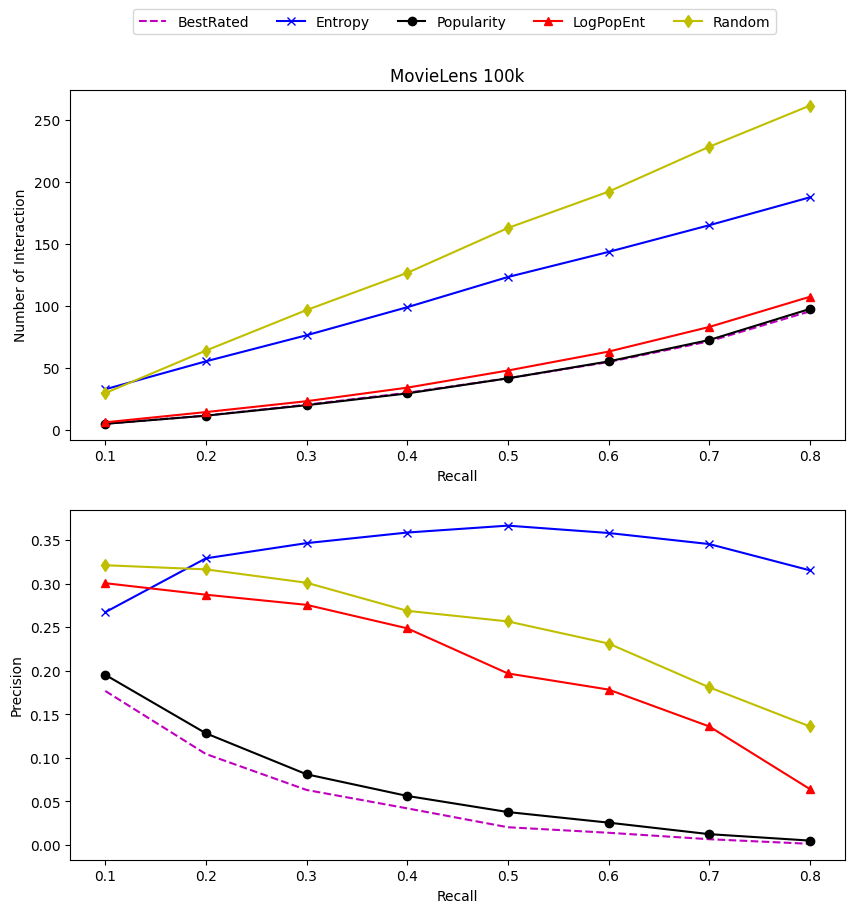

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1)

colors = ['m--', 'b-x', 'k-o', 'r-^', 'y-d', 'g']
exchange_points = [10, 20, 30, 40, 50, 60, 70, 80]

fig.set_size_inches(10, 10)

ax1.set_xticks((np.arange(0, 90, step=10)))
ax1.set_title("MovieLens 100k")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Number of Interaction")
ax1.xaxis.set_ticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"])

ax2.set_xticks((np.arange(0, 90, step=10)))
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.xaxis.set_ticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"])

for i, (method, results) in enumerate(metrics.items()):
    ax1.plot(exchange_points, [v["num_itr"] for k, v in results.items()], colors[i], label=method)
    ax2.plot(exchange_points, [v["precision"] for k, v in results.items()], colors[i], label=method)
    
plt.legend(bbox_to_anchor=(0.92, 2.45), ncol=len(metrics))
plt.show()